In [1]:
from sklearn.datasets import load_sample_image

In [2]:
import tensorflow as tf

In [3]:
import numpy as np

In [4]:
from matplotlib import pyplot as plt

In [5]:
# Load sample images
china = load_sample_image("china.jpg") / 255 # get color channels as floats from 0 to 1
flower = load_sample_image("flower.jpg") / 255

In [6]:
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [7]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

In [8]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

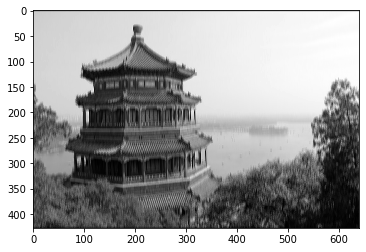

In [9]:
plt.imshow(outputs[0, :, :, 0], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

In [10]:
conv = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")

# Convolutional layer hyperparameters that can be optimized:
#     - number of filters
#     - their height and width
#     - strides
#     - padding type

In [11]:
# Fashion MNIST CNN
layers = tf.keras.layers
model = tf.keras.models.Sequential([
    layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=[28, 28, 1]),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, activation="relu", padding="same"),
    layers.Conv2D(128, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Conv2D(256, 3, activation="relu", padding="same"),
    layers.Conv2D(256, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5), 
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

In [12]:
# Implementing a ResNet-34 CNN Using Keras

In [13]:
class ResidualUnit(layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            layers.BatchNormalization(),
            self.activation,
            layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
          self.skip_layers = [
              layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
              layers.BatchNormalization()
          ]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [14]:
# Apply ResNet-34 (page 479)

In [15]:
model = tf.keras.models.Sequential()

model.add(layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], padding="same", use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(layers.GlobalAvgPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="softmax"))

In [16]:
res50 = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

In [17]:
images_resized = tf.image.resize(images, [224, 224])

In [18]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized * 255)

In [19]:
Y_proba = res50.predict(inputs)

In [20]:
Y_proba

array([[2.0904645e-08, 6.2080993e-08, 3.4869281e-08, ..., 3.0669649e-09,
        1.3305282e-07, 8.0237704e-08],
       [5.9631830e-08, 4.5335990e-05, 2.2300443e-07, ..., 3.2232270e-05,
        2.9146436e-03, 1.0838983e-05]], dtype=float32)

In [21]:
Y_proba.shape

(2, 1000)

In [22]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)

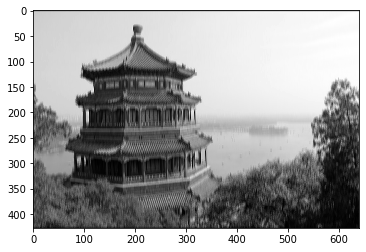

Image #0
 n02825657 - bell_cote    82.35
 n03877845 - palace       6.75
 n03781244 - monastery    4.19



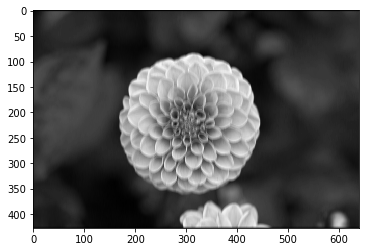

Image #1
 n03530642 - honeycomb    49.83
 n13040303 - stinkhorn    33.95
 n02206856 - bee          4.35



In [23]:
for image_index in range(len(images)):
    plt.imshow(outputs[image_index, :, :, 0], cmap="gray") # plot 1st image's 2nd feature map
    plt.show()
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print(" {} - {:12s} {:.2f}".format(class_id, name, y_proba * 100))

    print()

In [24]:
# Pretrained Models for Transfer Learning

In [25]:
import tensorflow_datasets as tfds

In [96]:
# Lifesaver
# https://stackoverflow.com/questions/56218014/how-to-acquire-tf-data-datasets-shape

In [48]:
dataset, info = tfds.load("tf_flowers", as_supervised=False, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670

class_names = info.features["label"].names # ["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes # 5

In [97]:
# test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10, 15, 75])

test_set = tfds.load(name="tf_flowers", split="train[:10%]", as_supervised=True)
valid_set = tfds.load(name="tf_flowers", split="train[10:25%]", as_supervised=True)
train_set = tfds.load(name="tf_flowers", split="train[25:100%]", as_supervised=True)

In [98]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [100]:
batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [101]:
# Load Xception model (pre-trained on ImageNet)
# Exclude global average pooling layer and dense output layer
# Add our own global average pooling layer (based on output of our base model) and Dense output layer

base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 121s 1us/step


In [103]:
# Freeze weights of pretrained layers
for layer in base_model.layers:
    layer.trainable = False

In [104]:
# Compile model and start training


#-------------------------------------------------------#
# Don't run these without a GPU or it will be very slow #
#-------------------------------------------------------#

# optimizer = tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
# model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
      1/Unknown - 13s 13s/step

KeyboardInterrupt: 

In [ ]:
#--------#
# OUTPUT #
#--------#

# Train for 86 steps, validate for 17 steps
# Epoch 1/5
# 86/86 [==============================] - 26s 303ms/step - loss: 0.8094 - accuracy: 0.7584 - val_loss: 2.8016 - val_accuracy: 0.6048
# Epoch 2/5
# 86/86 [==============================] - 16s 188ms/step - loss: 0.4182 - accuracy: 0.8786 - val_loss: 1.0660 - val_accuracy: 0.7941
# Epoch 3/5
# 86/86 [==============================] - 17s 195ms/step - loss: 0.3186 - accuracy: 0.8983 - val_loss: 1.2122 - val_accuracy: 0.7665
# Epoch 4/5
# 86/86 [==============================] - 17s 197ms/step - loss: 0.2634 - accuracy: 0.9102 - val_loss: 0.9475 - val_accuracy: 0.7868
# Epoch 5/5
# 86/86 [==============================] - 17s 200ms/step - loss: 0.2590 - accuracy: 0.9153 - val_loss: 0.9612 - val_accuracy: 0.7996

In [105]:
# After a few training epochs, validation accuracy reaches 75%-80%
# Top layers are well trained, so now we unfreeze all layers (or just top ones)
# Recompile model (now with unfrozen layers) and continue training
# Now we use a lower learning rate to avoid damaging pretrained weights

# for layer in base_model.layers:
#     layer.trainable = True
    
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
# model.compile(...)
# history = model.fit(...)

In [106]:
# To predict object's locations, predict horizontal and vertical coordinates of the object's center
# as well as height and width (4 numbers)

# To update the model, just add a second dense output layer with 4 units

In [ ]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
location_output = tf.keras.layers.Dense(4)(avg)

model = tf.keras.Model(
    inputs=base_model.input,
    outputs=[class_output, location_output]
)

model.compile(
    loss=["sparse_categorical_crossentropy", "mse"], 
    loss_weights=[0.8, 0.2], # depending on what you care about most
    optimizer=optimizer, 
    metrics=["accuracy"]
)